In [3]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy
import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt

import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import spatial_weights
import timeseries
import general_io as gio

In [4]:
%matplotlib inline

# Mass conservation

The first critical comparison related to mass conservation. In other words, we need to compare the water flux into sea water (wfo; time/lat/lon) against the global sea water mass (masso; time). It is also useful to compare these against the global mean sea water salinity (soga; time).

To be more specific, the comparable quantities are the cumulative wfo, sea water mass anomaly and inferred cumulative wfo from soga.

Assumption: The only way the mass of the global ocean can change is via freshwater flux at the ocean surface.

Assumption: The amount of salt in the ocean is fixed, so any change in mass/freshwater flux should be reflected in a corresponding change in global mean salinity 


### Global mean sea water salinity

In [63]:
def process_soga(model):
    """Process global mean sea water salinity control data"""
    
    file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/soga/latest/soga_*.nc' %(model)
    soga_files = glob.glob(file_pattern)
    
    soga_cube, history = gio.combine_files(soga_files, 'sea_water_salinity')
    soga_cube = gio.salinity_unit_check(soga_cube)
    soga_cube = timeseries.convert_to_annual(soga_cube)
        
    s_orig = numpy.ones(soga_cube.data.shape[0]) * soga_cube.data[0]
    wfo = numpy.fromiter(map(inferred_wfo, s_orig, soga_cube.data), float)

    return soga_cube, wfo

### Water flux into sea water

This variable represents the net freshwater flux at the ocean surface. In other words, it is ("probably" - direct quote from CMIP5 docs) the sum of:
* `pr`: rainfall flux
* `prsn`: snowfall flux
* `evs`: water evaporation flux
* `friver`: water flux into seawater from rivers
* `ficeberg`: water flux into seawater from ice bergs
* `fsitherm`: water flux into sea water due to sea ice thermodynamics

All of these are second priority variables (as is `wfo`) except for `fsitherm` (first priority), which means if `wfo` isn't archived there's not much chance all the components are. Also, most models that do archive `wfo` don't archive all the components, but you could probably get a good picture just from `pr`, `evs` and `friver`.

I'm assuming that means no models have any runoff due to glacier or ice cap melt, or perhaps those are included in river runoff?

It's worth noting how freshwater fluxes are represented differently across models, with some models converting the freshwater flux to a virtual salt flux (so that the volume of the ocean stays the same). [This paper](https://www.sciencedirect.com/science/article/pii/S2095927317300932) gives a good overview.

[In the CNRM-CM5 model wfo variable is positive upwards](http://www.umr-cnrm.fr/cmip5/spip.php?article24). I wonder if that's the case for other models? (TODO: Look at spatial fields to determine this.)

In [69]:
def process_wfo(model):
    """Process water flux into sea water data
    
    The units need to be converted from kg m-2 s-1 to kg in order
    to be able to work effectively with the salinity data (which is g/kg)
    
    """
    
    wfo_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/wfo/latest/wfo_*.nc' %(model)
    wfo_files = glob.glob(wfo_pattern)
    
    wfo_cube, history = gio.combine_files(wfo_files, 'water_flux_into_sea_water')
    wfo_cube = timeseries.convert_to_annual(wfo_cube)
    
    area_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/fx/ocean/r0i0p0/areacello/latest/areacello_*.nc' %(model)
    area_file = glob.glob(area_pattern)
    
    area_cube = iris.load_cube(area_file)
    area_array = uconv.broadcast_array(area_cube.data, [1, area_cube.ndim], wfo_cube.shape)
    
    units = str(wfo_cube.units)
    assert units == 'kg m-2 s-1'
    wfo_cube.units = units.replace('m-2', '')
    wfo_cube.data = wfo_cube.data * area_array

    # Calculate the global sum
    wfo_cube = wfo_cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=None)
    wfo_cube.remove_coord('latitude')
    wfo_cube.remove_coord('longitude')

    # Remove the s-1
    assert 'days' in str(wfo_cube.coord('time').units)
    time_span_days = wfo_cube.coord('time').bounds[:, 1] - wfo_cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    wfo_cube.data = wfo_cube.data * time_span_seconds
    units = str(wfo_cube.units)
    wfo_cube.units = units.replace('s-1', '')
    
    wfo_cumsum = numpy.cumsum(wfo_cube.data)

    return wfo_cube, wfo_cumsum

In [65]:
def process_masso(model):
    """Process sea water mass data"""
    
    file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/masso/latest/masso_*.nc' %(model)
    masso_files = glob.glob(file_pattern)
    masso_cube, history = gio.combine_files(masso_files, 'sea_water_mass')
    masso_cube = timeseries.convert_to_annual(masso_cube)
    masso_anomaly = masso_cube.data - masso_cube.data[0]

    return masso_cube, masso_anomaly

In [76]:
def plot_mass_conservation(model):
    """Do the three plots"""
    
    wfo, cumulative_wfo = process_wfo(model)
    soga, cumulative_wfo_inferred_from_soga = process_soga(model)
    masso, masso_anomaly = process_masso(model)
    
    fig = plt.figure(figsize=[16, 10])
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    
    ax1.plot(wfo.data, color='blue')
    ax1.set_title(wfo.long_name)
    ax1.set_xlabel('year')
    ax1.set_ylabel(wfo.units)
    ax1.ticklabel_format(useOffset=False)
    
    ax2.plot(soga.data, color='orange')
    ax2.set_xlabel('year')
    ax2.set_ylabel('salinity (g/kg)')
    ax2.set_title(soga.long_name)
    ax2.ticklabel_format(useOffset=False, style='plain')
    
    ax3.plot(masso.data, color='green')
    ax3.set_title(masso.long_name)
    ax3.set_xlabel('year')
    ax3.set_ylabel(masso.units)
    ax3.ticklabel_format(useOffset=False)
    
    ax4.plot(cumulative_wfo_inferred_from_soga, color='orange', label='change in soga')
    ax4.plot(cumulative_wfo, color='blue', label='cumulative wfo')
    ax4.plot(masso_anomaly, color='green', label='masso anomaly')
    ax4.set_title("inferred cumulative change in freshwater")
    ax4.set_xlabel('year')
    ax4.set_ylabel('kg')
    ax4.ticklabel_format(useOffset=False)
    ax4.legend()
    
    plt.suptitle(model)
    plt.show()

### Relationships

How are soga ($S$) and cumulative global total wfo ($\Delta M$) related?

$\Delta M = -M_{globe}(1 - \frac{S_{orig}}{S_{new}})$

where $M_{globe}$ is the mass of the global ocean. 

(This assumes that the total ocean salt content is constant in the CMIP5 models.)

In [32]:
def inferred_wfo(s_orig, s_new, v=1.35e18):
    """Calculate the inferred cumulative global total wfo for a given change in soga.
    
    wfo = net water flux into sea water
    soga = global mean sea water salinity
    v = volume of ocean (m3)
    
    """
    
    p = 1027  # kg/m3; average density of global ocean - could calculate from rhopoto data
    m_globe = v * p
    
    delta_m = -1 * m_globe * (1 - (s_orig / s_new))    
    
    return delta_m

Sanity check:

In [36]:
v = 1.35e18  # m3; volume of global ocean - could calculate from volcello data
p = 1027  # kg/m3
m_globe = v * p

In [37]:
(0.03 * m_globe) / (m_globe + 4.780862068965527e+19)

0.028999999999999998

In [38]:
(0.03 * m_globe) / (m_globe -4.472419354838706e+19)

0.031

So to compare the wfo and soga data I could plot the wfo timeseries against an inferred wfo timeseries constructed from soga data.

### piControl timeseries

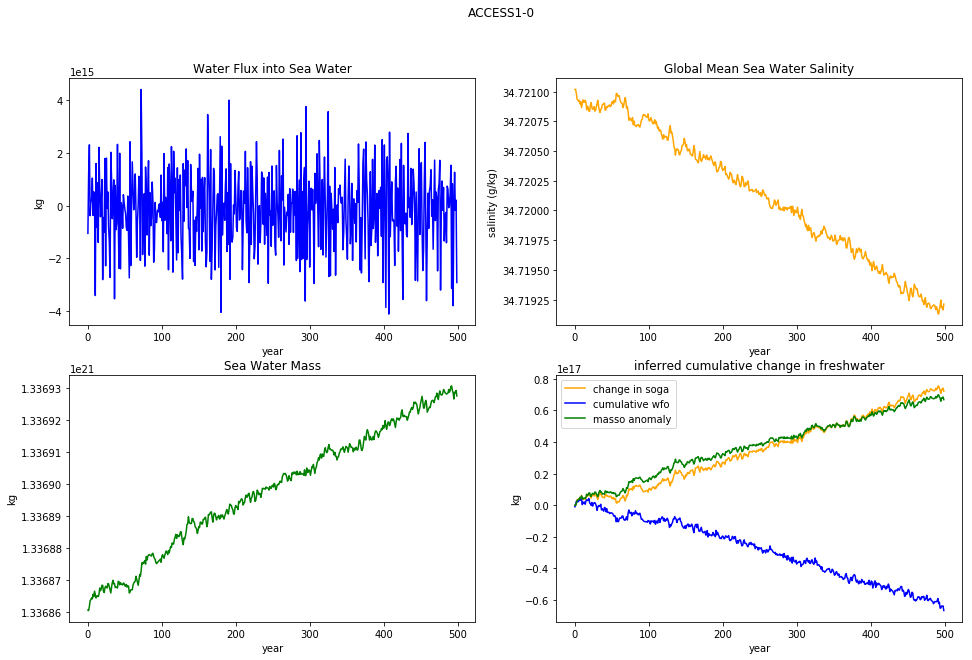

In [72]:
plot_mass_conservation('ACCESS1-0')

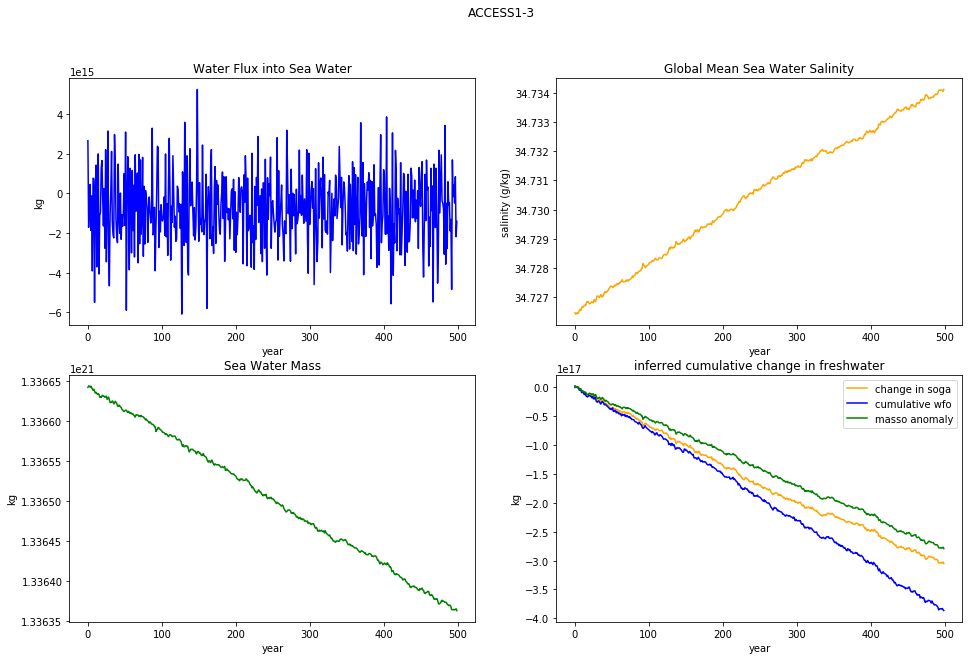

In [73]:
plot_mass_conservation('ACCESS1-3')

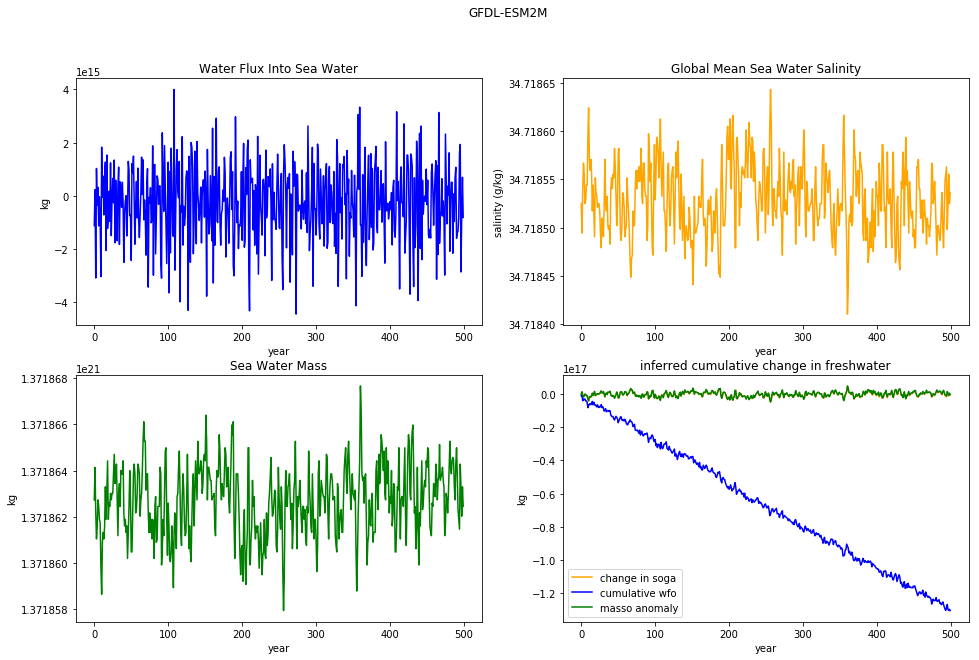

In [74]:
plot_mass_conservation('GFDL-ESM2M')

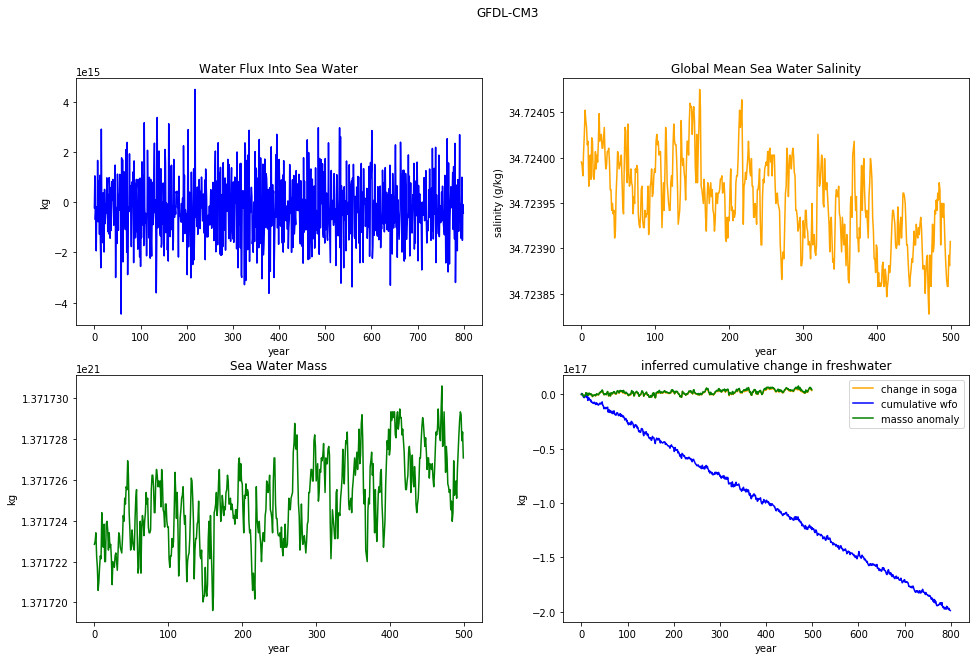

In [77]:
plot_mass_conservation('GFDL-CM3')

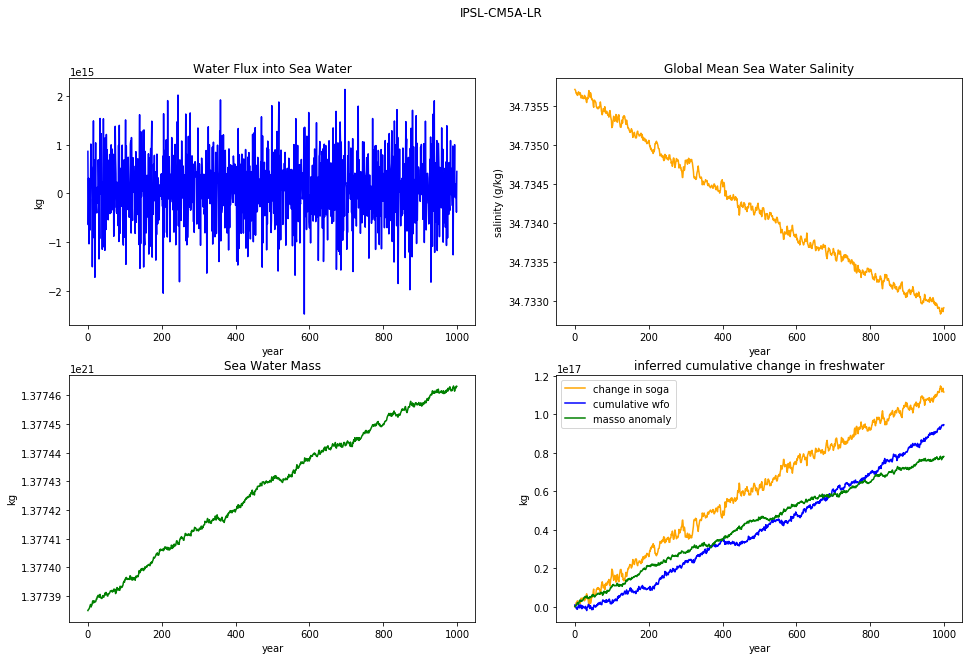

In [78]:
plot_mass_conservation('IPSL-CM5A-LR')

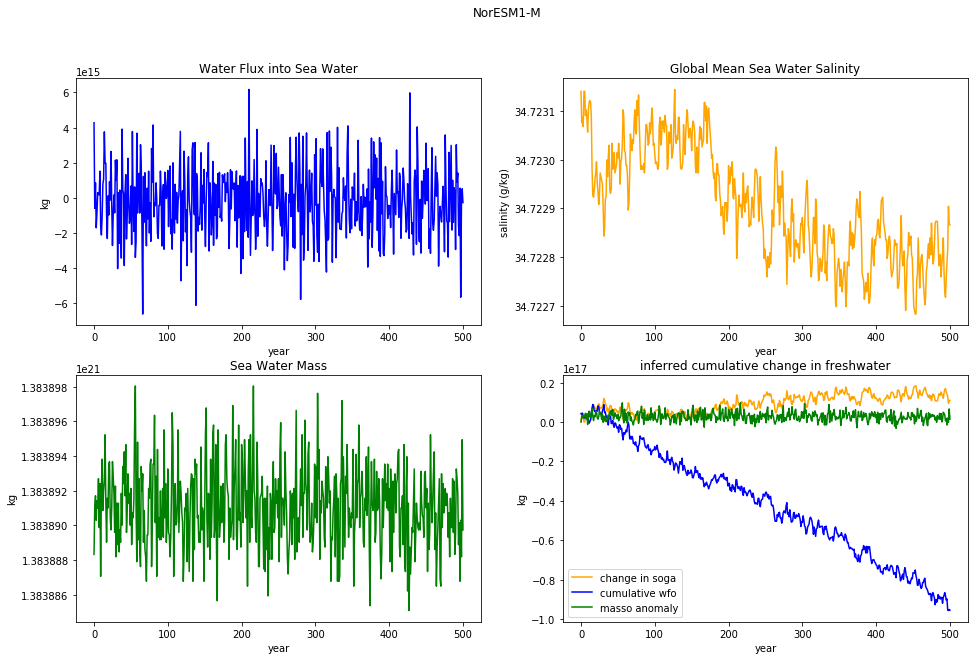

In [79]:
plot_mass_conservation('NorESM1-M')

### dedrifted timeseries

Inputs generated from `~/ocean-analysis/workflows/freshwater_drift.sh`.

In [13]:
def soga_to_wfo(soga_cube, wfo_dummy_cube, ocean_volume):
    """Convert from soga timeseries to wfo cumulative sum"""

    s_orig = numpy.ones(soga_cube.data.shape[0]) * soga_cube.data[0]
    v = numpy.ones(soga_cube.data.shape[0]) * ocean_volume
    wfo_cube = wfo_dummy_cube.copy()
    wfo_cube.data = numpy.fromiter(map(inferred_wfo, s_orig, soga_cube.data, v), float)
    
    return wfo_cube

In [16]:
def plot_drift(model, experiment, ylim=None, volcello_inferred=False):
    """Plot experiment data before and after dedrifting"""

    file_dir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/r1i1p1' %(model, experiment)
    if volcello_inferred:
        volcello_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/fx/ocean/r0i0p0/volcello/latest/volcello-inferred_fx_%s_historical_r0i0p0.nc' %(model, model)
    else:
        volcello_file = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/volcello/latest/volcello_fx_%s_historical_r0i0p0.nc' %(model, model)
    volume_cube = iris.load_cube(volcello_file)
    ocean_volume = volume_cube.data.sum()
    print('ocean volume:', ocean_volume, 'm3')
    
    # wfo data
    wfo_orig_file = '%s/wfo/latest/wfo-sum-hemispheric-metrics_Oyr_%s_%s_r1i1p1_cumsum-all.nc' %(file_dir, model, experiment)
    wfo_dedrifted_file = '%s/wfo/latest/dedrifted/wfo-globe-sum_Oyr_%s_%s_r1i1p1_cumsum-all.nc' %(file_dir, model, experiment)
    
    wfo_orig_cube = iris.load_cube(wfo_orig_file, 'Water Flux into Sea Water globe sum')
    wfo_orig_cube.data = wfo_orig_cube.data - wfo_orig_cube.data[0]
    
    wfo_dedrifted_cube = iris.load_cube(wfo_dedrifted_file, 'Water Flux into Sea Water globe sum')
    wfo_dedrifted_cube.data = wfo_dedrifted_cube.data - wfo_dedrifted_cube.data[0]
    
    # soga data
    soga_orig_file = '%s/soga/latest/soga_Oyr_%s_%s_r1i1p1_all.nc' %(file_dir, model, experiment)
    soga_dedrifted_file = '%s/soga/latest/dedrifted/soga_Oyr_%s_%s_r1i1p1_all.nc' %(file_dir, model, experiment)
    
    soga_orig_cube = iris.load_cube(soga_orig_file, 'sea_water_salinity')
    soga_dedrifted_cube = iris.load_cube(soga_dedrifted_file, 'sea_water_salinity')
    
    inferred_wfo_orig_cube = soga_to_wfo(soga_orig_cube, wfo_orig_cube, ocean_volume)
    inferred_wfo_dedrifted_cube = soga_to_wfo(soga_dedrifted_cube, wfo_dedrifted_cube, ocean_volume)
    
    # Create the plot
        
    iplt.plot(wfo_orig_cube, color='blue', linestyle='--')
    iplt.plot(wfo_dedrifted_cube, color='blue', label='wfo')

    iplt.plot(inferred_wfo_orig_cube, color='orange', linestyle='--')
    iplt.plot(inferred_wfo_dedrifted_cube, color='orange', label='wfo inferred from soga')

    if ylim:
        plt.ylim(ylim)
    
    plt.ylabel(inferred_wfo_orig_cube.units)
    plt.legend()
    plt.title(model + ', ' + experiment)
    plt.show()

ocean volume: 1.3735492558239864e+18 m3


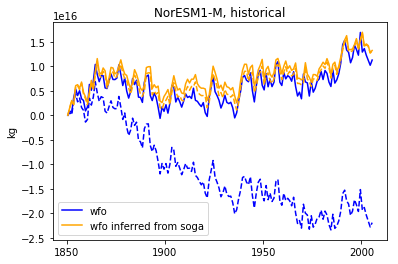

In [19]:
plot_drift('NorESM1-M', 'historical', volcello_inferred=True)

ocean volume: 1.3391147e+18 m3


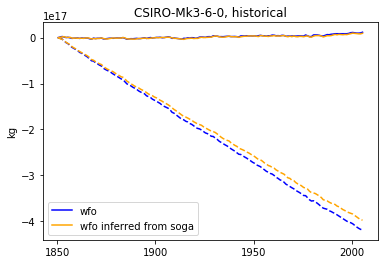

In [20]:
plot_drift('CSIRO-Mk3-6-0', 'historical')

ocean volume: 1.3391147e+18 m3


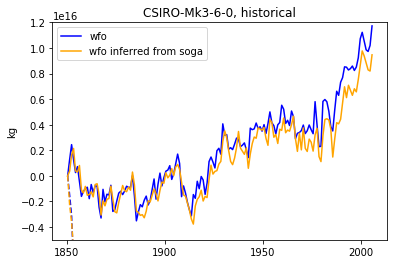

In [21]:
plot_drift('CSIRO-Mk3-6-0', 'historical', ylim=[-0.5e16, 1.2e16])

ocean volume: 1.3391147e+18 m3


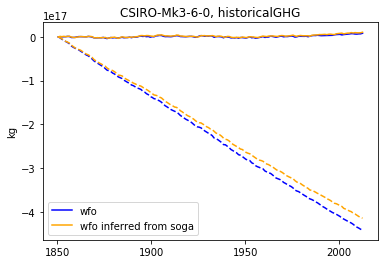

In [22]:
plot_drift('CSIRO-Mk3-6-0', 'historicalGHG')

ocean volume: 1.3391147e+18 m3


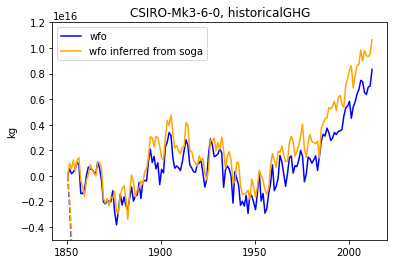

In [23]:
plot_drift('CSIRO-Mk3-6-0', 'historicalGHG', ylim=[-0.5e16, 1.2e16])

ocean volume: 1.3761059837019945e+18 m3


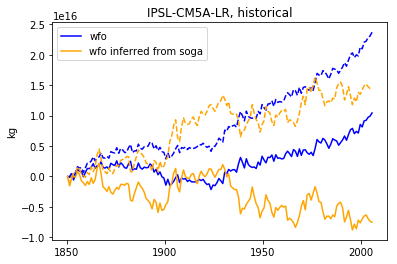

In [25]:
plot_drift('IPSL-CM5A-LR', 'historical', volcello_inferred=True)

### Full moisture budget

If I was going to do a full water budget, the following variables could be used:

* prw: `atmosphere_water_vapour_content` (water vapour path; Amon)
* mrso: `soil_moisture_content` (total soil moisture content; Lmon)
* lwsnl: `liquid_water_content_of_snow_layer` (LImon)
* pflw: `liquid_water_content_of_permafrost_layer` (LImon)
* sim: `sea_ice_and_surface_snow_amount` (OImon)

Many are very low priority and probably wouldn't be archived, plus it seems like there are missing terms relating to land ice.

# Sea level versus ocean volume

The second comparison to make is the global sea water volume (volo; time) versus global average sea level change (zosga). We can use areacello data to relate the change in volo to zosga.

Assumption: The only way the global average sea level can change is if the volume of the global ocean changes.

In [18]:
def plot_volo_vs_zosga(model):
    """Plot global average sea surface height above geoid"""
    
    volo_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/volo/latest/volo_*.nc' %(model)
    volo_files = glob.glob(volo_file_pattern)
    volo_cube, history = gio.combine_files(volo_files, 'sea_water_volume')
    volo_cube = timeseries.convert_to_annual(volo_cube)
    
    zosga_file_pattern = '/g/data/ua6/DRSv3/CMIP5/%s/piControl/mon/ocean/r1i1p1/zosga/latest/zosga_*.nc' %(model)
    zosga_files = glob.glob(zosga_file_pattern)
    zosga_cube, history = gio.combine_files(zosga_files, 'global_average_sea_level_change')
    zosga_cube = timeseries.convert_to_annual(zosga_cube)

    fig = plt.figure(figsize=[21, 5])
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    volo_anomaly = volo_cube.data - volo_cube.data[0]
    ax1.plot(volo_anomaly, color='green')
    ax1.set_title("volo anomaly")
    ax1.set_xlabel('year')
    ax1.set_ylabel(volo_cube.units)
    ax1.ticklabel_format(useOffset=False)
    
    #sftof_file = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/sftof/latest/sftof_fx_%s_historical_r0i0p0.nc' %(model, model)
    #sftof_cube = iris.load_cube(sftof_file)
    
    areacello_file = '/g/data/ua6/DRSv3/CMIP5/%s/historical/fx/ocean/r0i0p0/areacello/latest/areacello_fx_%s_historical_r0i0p0.nc' %(model, model)
    areacello_cube = iris.load_cube(areacello_file)
    #ocean_area = areacello_cube.data * (sftof_cube.data * 0.01)
    inferred_zosga = volo_anomaly / areacello_cube.data.sum()
    
    ax2.plot(zosga_cube.data, color='blue', label='actual')
    ax2.plot(inferred_zosga, color='green' ,label='inferred')
    ax2.set_title("zosga")
    ax2.set_xlabel('year')
    ax2.set_ylabel('m')
    ax2.ticklabel_format(useOffset=False)
    ax2.legend()
    
    ax3.plot(inferred_zosga - zosga_cube.data, color='purple')
    ax3.set_title("volo inferred - zosga")
    ax3.set_xlabel('year')
    ax3.set_ylabel('m')
    ax3.ticklabel_format(useOffset=False)
    
    plt.suptitle(model)
    plt.show()

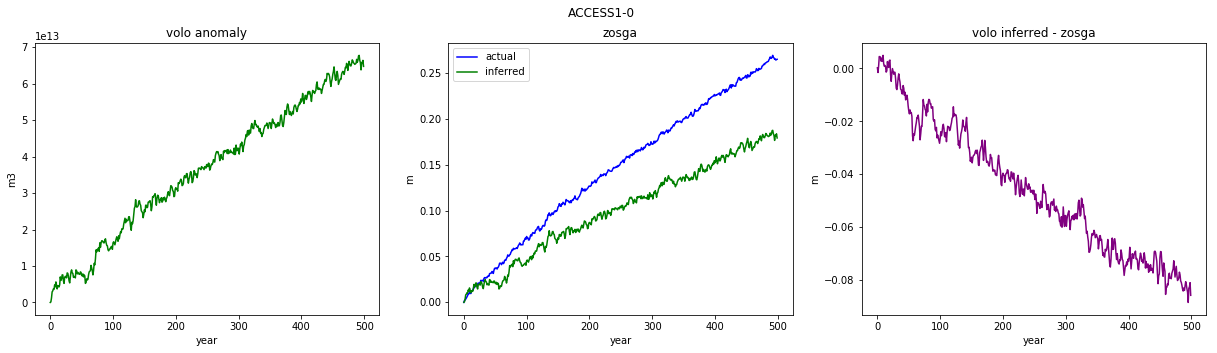

In [19]:
plot_volo_vs_zosga('ACCESS1-0')

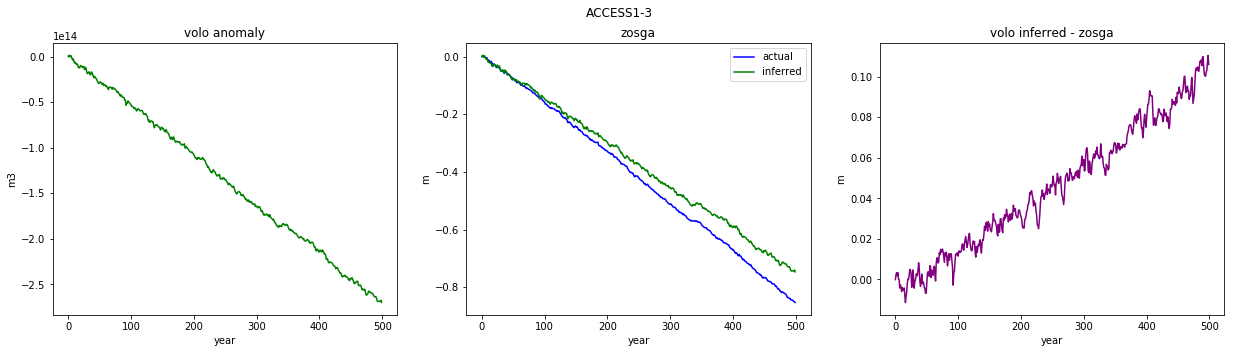

In [27]:
plot_volo_vs_zosga('ACCESS1-3')

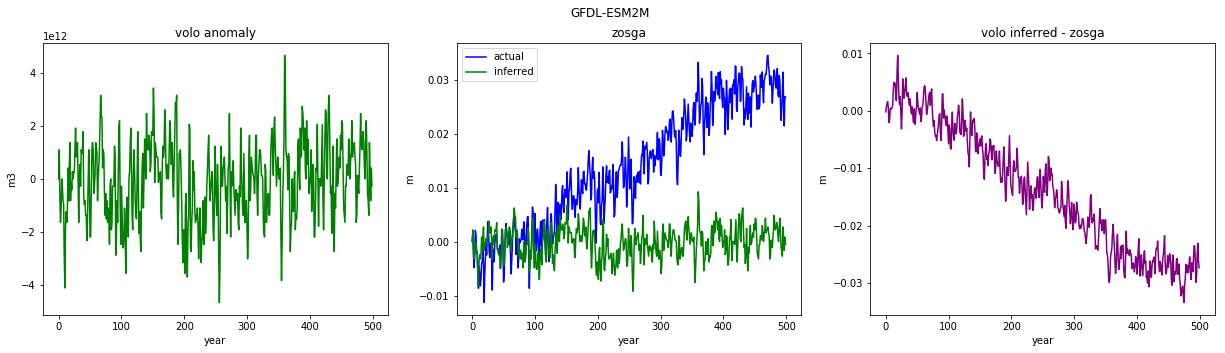

In [28]:
plot_volo_vs_zosga('GFDL-ESM2M')

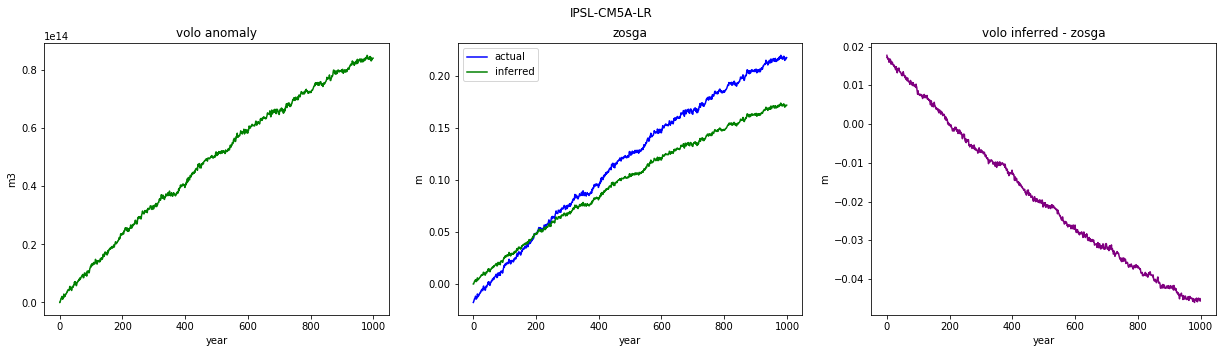

In [46]:
plot_volo_vs_zosga('IPSL-CM5A-LR')

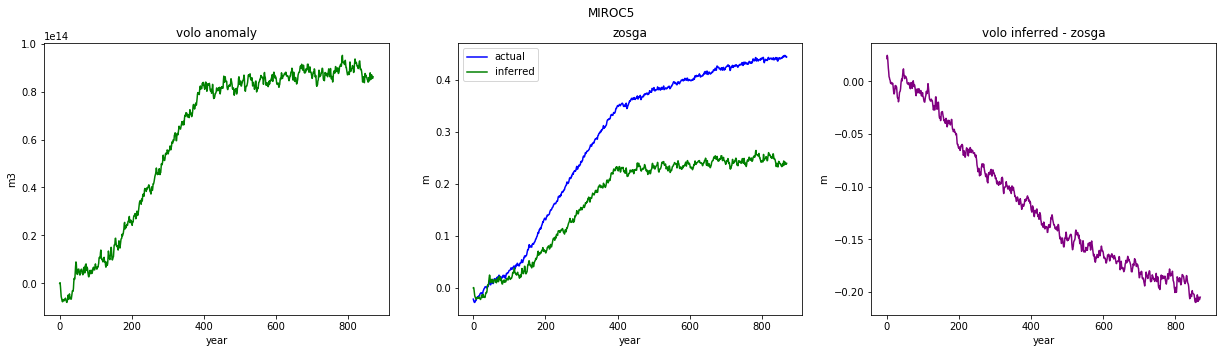

In [48]:
plot_volo_vs_zosga('MIROC5')

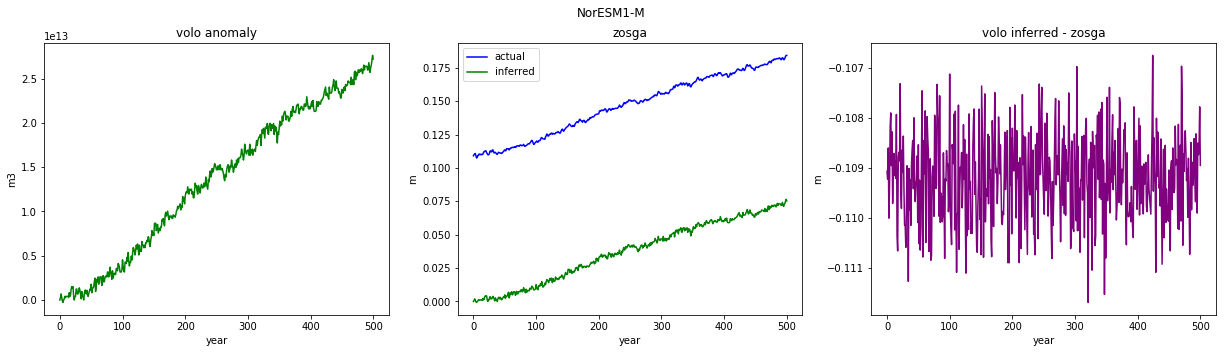

In [47]:
plot_volo_vs_zosga('NorESM1-M')

It looks like the inferred zosga is always a little smaller than the real zosga. This probably suggests an issue with dividing volo by the area of the ocean surface (i.e. the calculated area of the global ocean is too large).

Combine the areacello data with the ocean area fraction (sftof) data didn't help...